# Detecting Human Activities Through Smartphone Sensor - Training

## Imports

In [1]:
# TF related imports
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#scikit related imports
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix

# other generic imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from mlxtend import plotting
from tqdm import tqdm
from datetime import timedelta
import time



2024-11-20 03:06:04.116295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 03:06:04.131074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 03:06:04.135572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 03:06:04.147084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 03:06:04.926127: W tensorflow/comp

## Global Variables

In [2]:
# global variables
PBAR_FORMAT='{desc:12} {percentage:3.0f}%|{bar:27}| [ {n:4d}/{total:4d}, {elapsed}<{remaining}{postfix} ]'

ACTIVITY_CODES_MAPPING = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}
# csv file column names
COL_NAMES =  ['id' , 'activity_code' , 'timestamp', 'x', 'y', 'z']
# training verbose
VERBOSE = 1
# rnadom state for split
RANDOM_STATE=12345



## Dataset, Model and Trainer

### Helper functions

In [3]:
def get_activity_code(activity_names):
    cat_len=len(activity_names)
    activity_code={}
    for idx, an in enumerate(activity_names):
        for k in ACTIVITY_CODES_MAPPING.keys() :
            if ACTIVITY_CODES_MAPPING[k]==an:
                key = k
        activity_code[key]=idx
    
    assert(len(activity_code.keys())== cat_len)
    
    print(f"{activity_code}")
    print(f"Number of Categories {cat_len}")
    return activity_code, cat_len

def sliding_window(dataset, window_size, step_size):  
    x_list, y_list, z_list = [], [], []
    targets_list = []
    for i in range(0, dataset.shape[0] - window_size, step_size):
        x_list.append(dataset["x"].values[i: i + window_size])
        y_list.append(dataset["y"].values[i: i + window_size])
        z_list.append(dataset["z"].values[i: i + window_size])
        targets_list.append(stats.mode(dataset["activity_code"][i: i + window_size])[0])

    feature_list = [x_list, y_list, z_list]

    feature_list = [np.array(data_list) for data_list in feature_list]
    dataset = np.stack(feature_list, axis = 2)

    return dataset, targets_list

### Dataset

In [4]:
def WISDM_Dataset(dir, window_size, step_size, activity_code):
    window_size = window_size
    step_size = step_size
    path = dir
    column_names = COL_NAMES
    activity_dic = activity_code
    filelist_train = sorted([txt for txt in os.listdir(path + "/") if txt[-4:] == ".txt"])
    columns = ["x", "y", "z"]
        
    # Training data
    dataset_train = pd.DataFrame()

    for txt in tqdm(filelist_train, desc="loading data", bar_format=PBAR_FORMAT):
        dataset_tmp = pd.read_csv(path + '/' + txt, header = None, names = column_names, comment = ";")
        for k in activity_dic.keys():
            df_tmp = dataset_tmp[dataset_tmp['activity_code']==k][0:2400]
            dataset_train = pd.concat([dataset_train, df_tmp])
    print(dataset_train)

    # normalize the data
    dataset_train["activity_code"] = dataset_train["activity_code"].map(activity_dic)
    labels = dataset_train["activity_code"].to_numpy()

    scaler = RobustScaler()
    dataset_train = scaler.fit_transform(dataset_train[["x", "y", "z"]])
    dataset_train = pd.DataFrame(data = dataset_train, columns = ["x", "y", "z"])
    dataset_train["activity_code"] = labels
    
    # feature engineering
    dataset_train, targets_list = sliding_window(dataset_train, window_size, step_size)
    targets = np.array(targets_list)
    return dataset_train, targets

### Model

In [5]:
def gru_net(data, num_classes):
    x_input = layer.Input(shape = (data.shape[-2:]))
    x = layer.Bidirectional(layer.GRU(512, return_sequences = True))(x_input)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.GRU(256, return_sequences = True))(x)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.GRU(128, return_sequences = True))(x)
    x = layer.BatchNormalization()(x)

    x = layer.Flatten()(x)

    x = layer.Dense(128, activation = "relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(num_classes, activation = "softmax")(x)

    model = Model(inputs = x_input, outputs = x_output, name = "GRU_NET")

    return model


### Plotting function

In [6]:
def plot_loss_acc(epochs, train_losses, train_acc, test_losses, test_acc, fold):
    fig, ax1 = plt.subplots()
    xaxis = list(range(1, epochs + 1))
    plt_train_loss = ax1.plot(xaxis, train_losses, label = "Training Loss", color="red")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2 = ax1.twinx()
    plt_train_acc = ax2.plot(xaxis, train_acc, label = "Training Accuracy", color="green")
    ax2.set_ylabel("Accuracy in %")
    ax2.set_ylim(0.0, 100.0)

    plt_val_loss = ax1.plot(xaxis, test_losses, label = "Validation Loss", color="firebrick")
    plt_val_acc = ax2.plot(xaxis, test_acc, label = "Validation Accuracy", color="limegreen")

    lines = plt_train_loss + plt_train_acc + plt_val_loss + plt_val_acc
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels)
    fold = " Fold " + str(fold) 
    plt.title("Loss and Accuracy" + fold)
    plt.show()

def plot_confusion_matrix(y_pred, y_valid, fold):
    conf_matrix = confusion_matrix(y_valid, y_pred)
    plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                                   class_names = ACTIVITY_NAMES,
                                   show_normed = True,
                                   figsize = (10, 7),
                                   colorbar = True)
    plt.title("Confusion matrix Fold " + str(fold))
    plt.show()



### Trainer function

In [7]:

def train(data_dir, num_splits, window_size, step_size, activity_names, batch_size, num_epochs):
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    activity_code, cat_len = get_activity_code(activity_names)
    # Dataset
    train, targets = WISDM_Dataset(dir = data_dir,
                                  window_size = window_size,
                                  step_size = step_size,
                                  activity_code = activity_code)
      
    k_fold = KFold(n_splits = num_splits,
                   shuffle = True,
                   random_state = RANDOM_STATE)
    val_acc_last = []
    
    model = gru_net(train, cat_len)
    print(model.summary())
    start_time = time.time()
    for fold, (train_index, test_index) in enumerate(k_fold.split(train, targets)):
        print(f"Running fold: {fold}")
        x_train, x_valid = train[train_index], train[test_index]
        y_train, y_valid = targets[train_index], targets[test_index]
        
        # convert to tf dataset
        train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).with_options(options)
        valid_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size).with_options(options)
        
        model = gru_net(train, cat_len)
        
        model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
        
        learning_rate = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = VERBOSE)
        early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, verbose = VERBOSE, mode = "min", 
                                       restore_best_weights = True)
        
        # model training
        history = model.fit(train_data, 
                            validation_data = valid_data, 
                            epochs = num_epochs,
                            verbose = VERBOSE,    # for debugging VERBOSE
                            batch_size = BATCH_SIZE, 
                            callbacks = [learning_rate, early_stopping])
        
        # Plot loss and accuracy curves
        plot_loss_acc(len(history.history["loss"]), history.history["loss"], 
                                  [acc * 100.0 for acc in history.history["accuracy"]], 
                                  history.history["val_loss"], 
                                  [acc * 100.0 for acc in history.history["val_accuracy"]], str(fold))
        
        val_acc_last.append(np.around(100.0 * history.history["val_accuracy"][-1], 2))    # safe last validation accuracy
        
        # Plot confusion matrix
        y_pred = np.argmax(model.predict(valid_data, batch_size = BATCH_SIZE), axis = 1)
        print("\n")
        plot_confusion_matrix(y_pred, y_valid, fold) 
        print(f'Time elapsed: {timedelta(microseconds=int((time.time()-start_time)*1000000))}')

    print(f'Total Training Time: {timedelta(seconds=int(time.time()-start_time))}')
    print("Val Acc per fold:", val_acc_last)


## Training on watch accelerometer

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'K': 8, 'M': 9, 'O': 10, 'P': 11, 'Q': 12, 'R': 13, 'S': 14}
Number of Categories 15


loading data 100%|███████████████████████████| [   51/  51, 00:14<00:00 ]


         id activity_code         timestamp         x         y         z
0      1600             A    90426708196641  7.091625 -0.591667  8.195502
1      1600             A    90426757696641  4.972757 -0.158317  6.696732
2      1600             A    90426807196641  3.253720 -0.191835  6.107758
3      1600             A    90426856696641  2.801216 -0.155922  5.997625
4      1600             A    90426906196641  3.770868 -1.051354  7.731027
...     ...           ...               ...       ...       ...       ...
65386  1650             S  2426124382870752  6.425738 -6.462100  1.874061
65387  1650             S  2426124432864802  6.267721 -6.217891  1.682525
65388  1650             S  2426124482858852  5.822399 -6.553080  1.079186
65389  1650             S  2426124532852902  5.590162 -7.029526  0.504578
65390  1650             S  2426124582846952  5.702689 -7.668778  0.317830

[1826400 rows x 6 columns]


2024-11-20 03:06:29.332580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6634 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "GRU_NET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 1024)      │     1,588,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 512)       │     1,969,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 256)       │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,613,775 (40.49 MB)

 Trainable params: 10,609,935 (40.47 MB)

 Non-trainable params: 3,840 (15.00 KB)

None
Running fold: 0
Epoch 1/90


2024-11-20 03:06:35.001040: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 349ms/step - accuracy: 0.2315 - loss: 2.9347 - val_accuracy: 0.2483 - val_loss: 2.3221 - learning_rate: 0.0010
Epoch 2/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step - accuracy: 0.4174 - loss: 1.8323 - val_accuracy: 0.2874 - val_loss: 2.3764 - learning_rate: 0.0010
Epoch 3/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.5073 - loss: 1.5369 - val_accuracy: 0.3397 - val_loss: 2.4694 - learning_rate: 0.0010
Epoch 4/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.5984 - loss: 1.2588 - val_accuracy: 0.4010 - val_loss: 2.3386 - learning_rate: 0.0010
Epoch 5/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6615 - loss: 1.0666 - val_accuracy: 0.4492 - val_loss: 2.1372 - learning_rate: 0.0010
Epoch 6/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.7111 - loss: 0.9079 - val_accuracy: 0.5760 - val_loss: 1.5661 - learning_rate: 0.0010
Epoch 7/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.7335 - loss: 0.8215 - val_

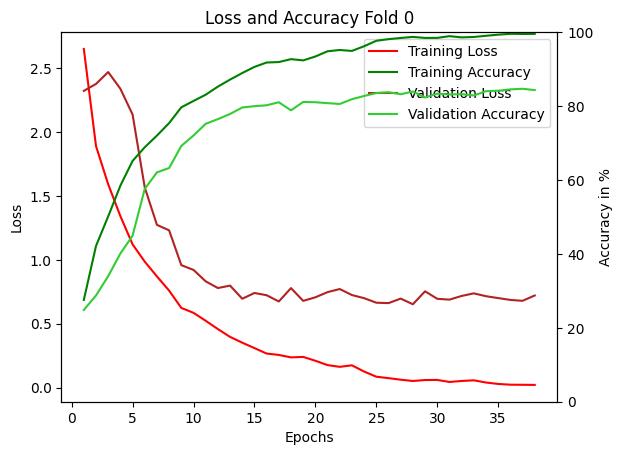

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step




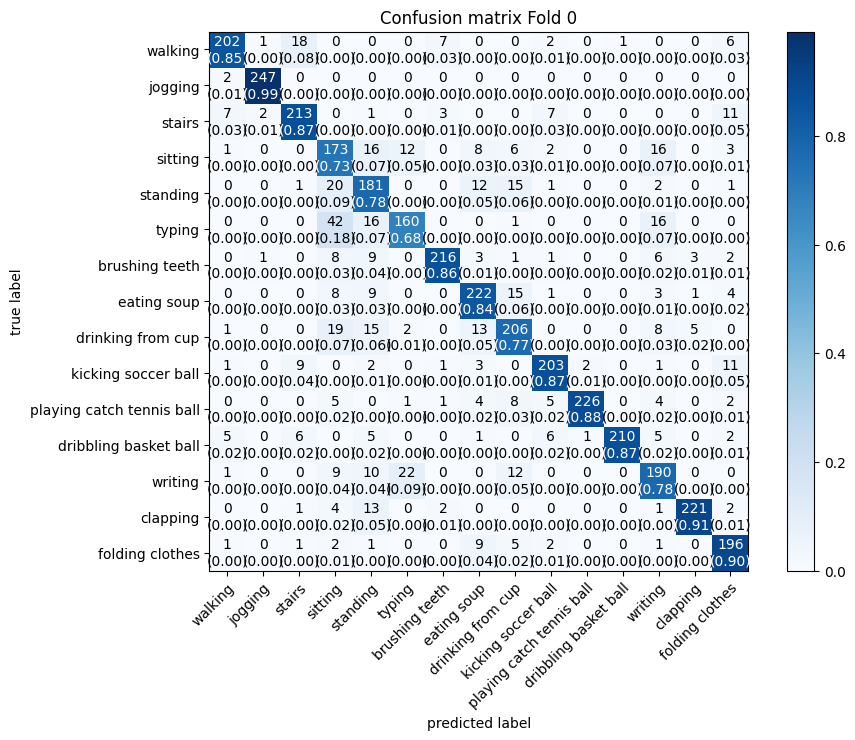

Time elapsed: 0:13:07.473330
Running fold: 1
Epoch 1/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 359ms/step - accuracy: 0.2307 - loss: 3.0259 - val_accuracy: 0.2428 - val_loss: 2.5592 - learning_rate: 0.0010
Epoch 2/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.4180 - loss: 1.8999 - val_accuracy: 0.2228 - val_loss: 2.3540 - learning_rate: 0.0010
Epoch 3/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.5096 - loss: 1.5692 - val_accuracy: 0.2644 - val_loss: 2.4144 - learning_rate: 0.0010
Epoch 4/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.5968 - loss: 1.2493 - val_accuracy: 0.3186 - val_loss: 2.1899 - learning_rate: 0.0010
Epoch 5/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.6511 - loss: 1.0688 - val_accuracy: 0.4394 - val_loss: 1.9446 - learning_rate: 0.0010
Epoch 6/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.6951 - loss: 0.9427 - val_accuracy: 0.4977 - val_loss: 1.7533 - learning_rate: 0.0010
Epoch 7/90
58/58 ━━━━━━━━━━━━━━━━━━━━

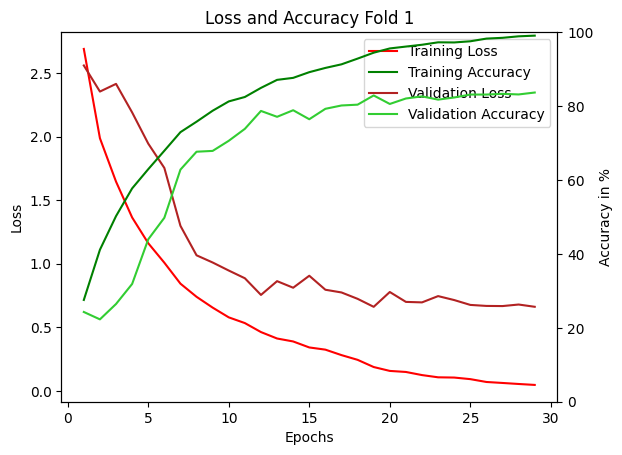

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step




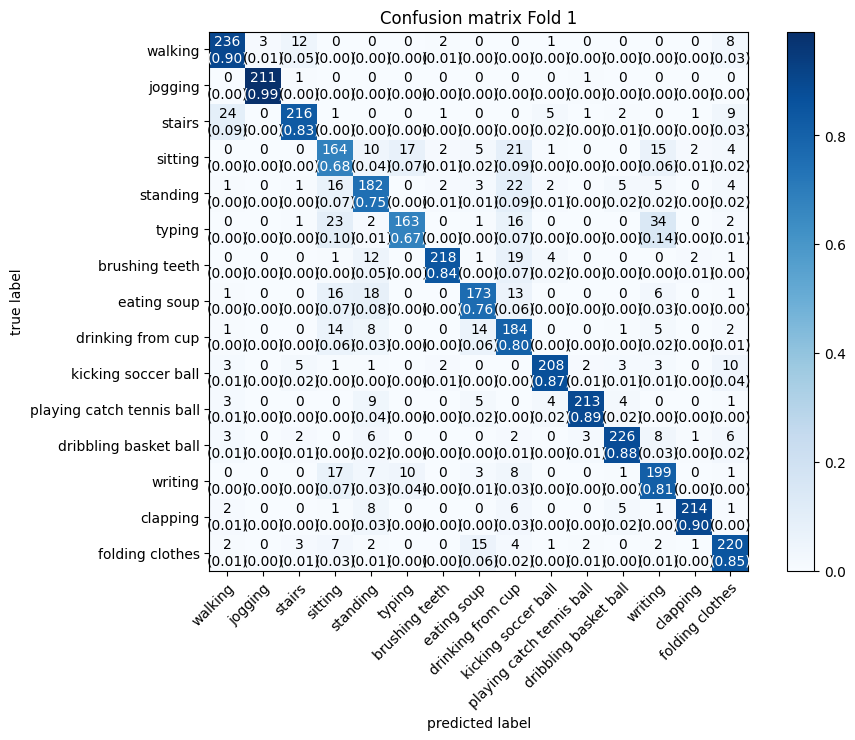

Time elapsed: 0:23:14.041678
Running fold: 2
Epoch 1/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - accuracy: 0.2523 - loss: 2.9345 - val_accuracy: 0.2651 - val_loss: 2.2405 - learning_rate: 0.0010
Epoch 2/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.4250 - loss: 1.8799 - val_accuracy: 0.3174 - val_loss: 2.1249 - learning_rate: 0.0010
Epoch 3/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.5230 - loss: 1.5000 - val_accuracy: 0.3442 - val_loss: 2.1962 - learning_rate: 0.0010
Epoch 4/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.6027 - loss: 1.2183 - val_accuracy: 0.4189 - val_loss: 2.1070 - learning_rate: 0.0010
Epoch 5/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6673 - loss: 1.0232 - val_accuracy: 0.4318 - val_loss: 2.0383 - learning_rate: 0.0010
Epoch 6/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.7105 - loss: 0.8918 - val_accuracy: 0.5099 - val_loss: 1.6990 - learning_rate: 0.0010
Epoch 7/90
58/58 ━━━━━━━━━━━━━━━━━━━━

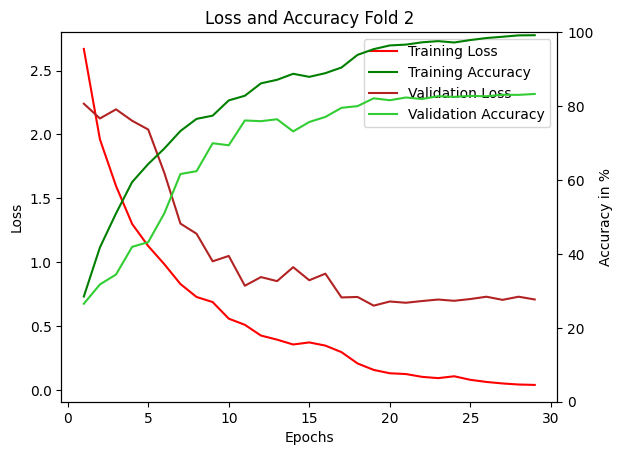

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step




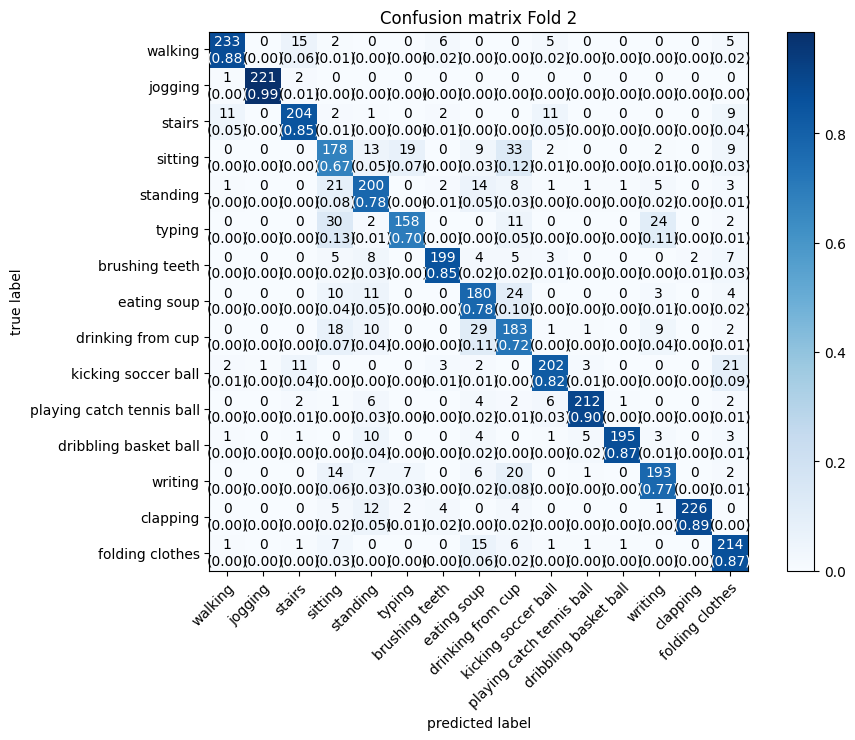

Time elapsed: 0:33:21.616541
Running fold: 3
Epoch 1/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - accuracy: 0.2625 - loss: 2.9241 - val_accuracy: 0.2552 - val_loss: 2.3936 - learning_rate: 0.0010
Epoch 2/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.4149 - loss: 1.9298 - val_accuracy: 0.2998 - val_loss: 2.1056 - learning_rate: 0.0010
Epoch 3/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.5070 - loss: 1.5661 - val_accuracy: 0.3984 - val_loss: 2.0080 - learning_rate: 0.0010
Epoch 4/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.5787 - loss: 1.3095 - val_accuracy: 0.4469 - val_loss: 1.8956 - learning_rate: 0.0010
Epoch 5/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.6526 - loss: 1.0837 - val_accuracy: 0.5214 - val_loss: 1.6395 - learning_rate: 0.0010
Epoch 6/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6987 - loss: 0.9143 - val_accuracy: 0.5780 - val_loss: 1.4695 - learning_rate: 0.0010
Epoch 7/90
58/58 ━━━━━━━━━━━━━━━━━━━━

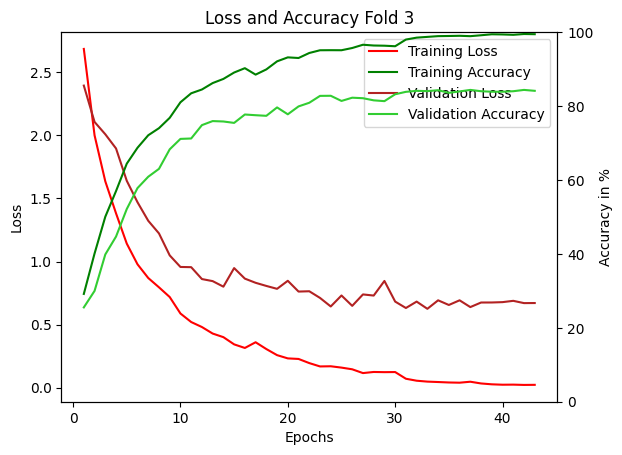

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step




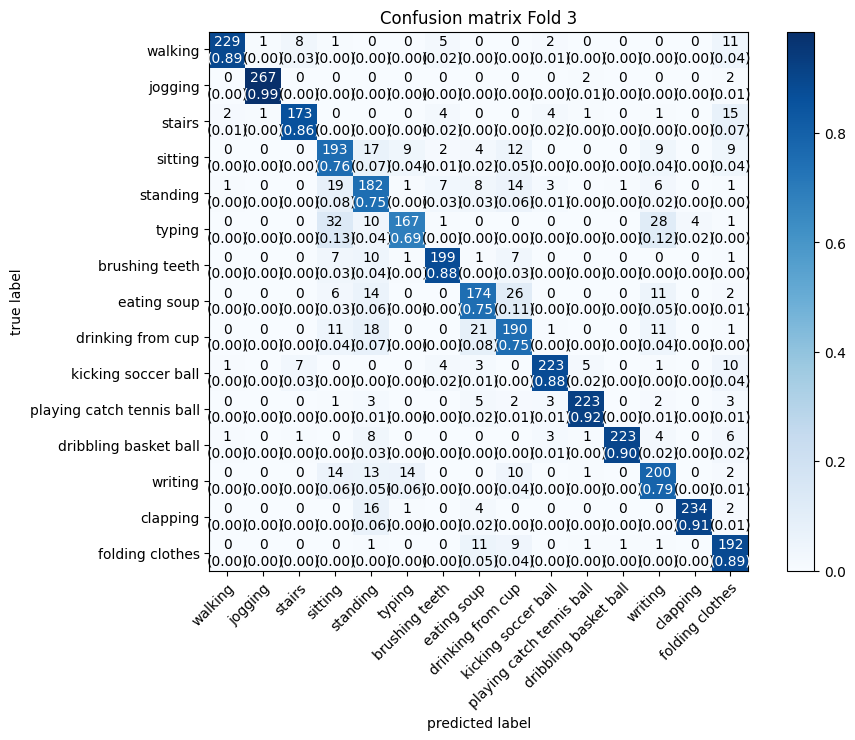

Time elapsed: 0:48:19.072534
Running fold: 4
Epoch 1/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 357ms/step - accuracy: 0.2381 - loss: 3.0590 - val_accuracy: 0.2596 - val_loss: 2.4691 - learning_rate: 0.0010
Epoch 2/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.4356 - loss: 1.8239 - val_accuracy: 0.2412 - val_loss: 2.7529 - learning_rate: 0.0010
Epoch 3/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.5412 - loss: 1.4545 - val_accuracy: 0.2870 - val_loss: 2.6803 - learning_rate: 0.0010
Epoch 4/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.6078 - loss: 1.2064 - val_accuracy: 0.3691 - val_loss: 2.1559 - learning_rate: 0.0010
Epoch 5/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.6685 - loss: 1.0526 - val_accuracy: 0.4154 - val_loss: 2.0586 - learning_rate: 0.0010
Epoch 6/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.7108 - loss: 0.9080 - val_accuracy: 0.5430 - val_loss: 1.5699 - learning_rate: 0.0010
Epoch 7/90
58/58 ━━━━━━━━━━━━━━━━━━━━

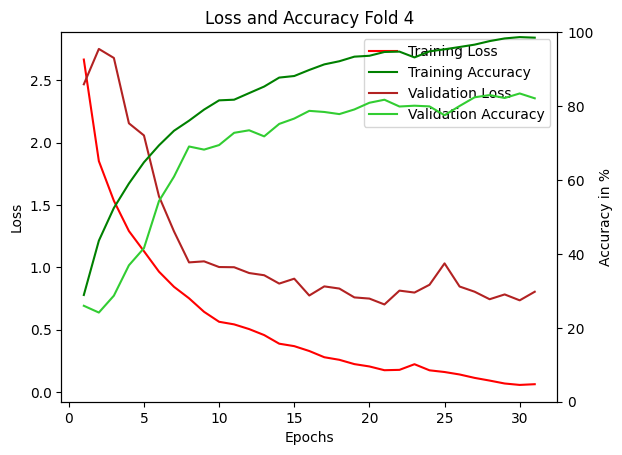

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step




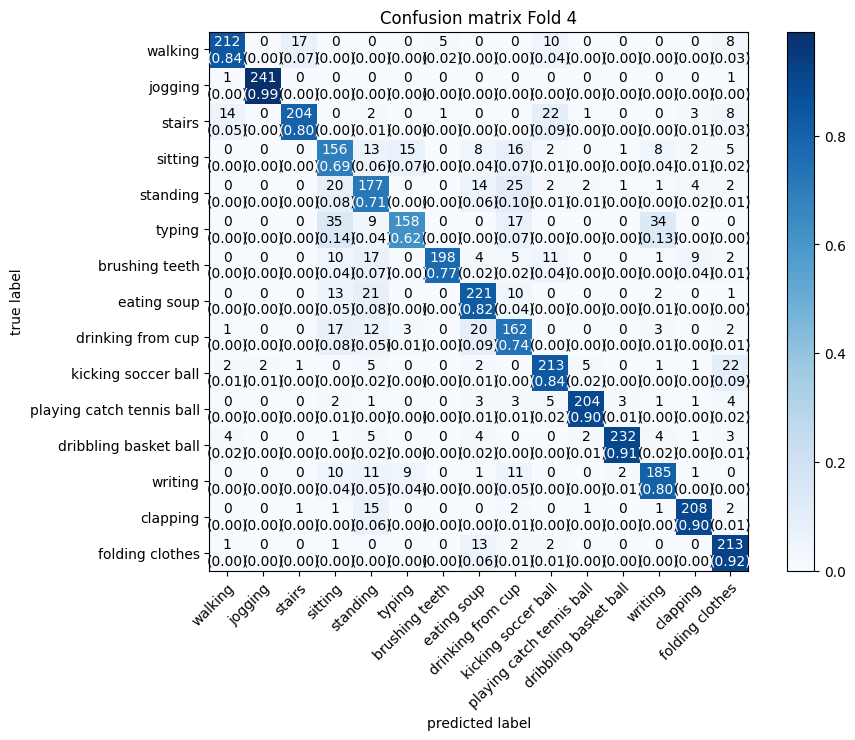

Time elapsed: 0:59:06.344478
Total Training Time: 0:59:06
Val Acc per fold: [84.31, 83.66, 83.27, 84.12, 82.09]


In [8]:
##################################################################
#Hyperparameter
##################################################################
#ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "kicking soccer ball"]
ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "drinking from cup", 
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball", 
                  "writing", "clapping", "folding clothes"]
NUM_EPOCHS  = 90
BATCH_SIZE = 256
WINDOW_SIZE=200
STEP_SIZE=100
NUM_SPLITS=5
DATA_DIR="../dataset/raw/watch/accel"

##################################################################
#Training
##################################################################
train(data_dir=DATA_DIR,
      num_splits=NUM_SPLITS,
      window_size=WINDOW_SIZE,
      step_size=STEP_SIZE,
      activity_names=ACTIVITY_NAMES,
      batch_size=BATCH_SIZE,
      num_epochs=NUM_EPOCHS)


## Training on watch gyroscope sensor

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'K': 8, 'M': 9, 'O': 10, 'P': 11, 'Q': 12, 'R': 13, 'S': 14}
Number of Categories 15


loading data 100%|███████████████████████████| [   51/  51, 00:12<00:00 ]


         id activity_code         timestamp         x         y         z
0      1600             A    90426757696641  0.314944 -1.022277 -0.309962
1      1600             A    90426807196641  0.387382 -0.618541 -0.048972
2      1600             A    90426856696641  0.070999 -0.209480 -0.195978
3      1600             A    90426906196641  0.037975  0.254976 -0.156563
4      1600             A    90426955696641  0.073129  0.719431 -0.001035
...     ...           ...               ...       ...       ...       ...
65352  1650             S  2426124432864802 -0.761755  1.007815 -0.567129
65353  1650             S  2426124482858852 -1.278409  1.254957 -0.672590
65354  1650             S  2426124532852902 -1.342324  1.273066 -0.770594
65355  1650             S  2426124582846952 -1.215558  1.024859 -0.732245
65356  1650             S  2426124632841002 -0.984396  0.541229 -0.325314

[1814400 rows x 6 columns]


Model: "GRU_NET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 200, 1024)      │     1,588,224 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 200, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 200, 512)       │     1,969,152 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 200, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 200, 256)       │       493,056 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 200, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,613,775 (40.49 MB)

 Trainable params: 10,609,935 (40.47 MB)

 Non-trainable params: 3,840 (15.00 KB)

None
Running fold: 0
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 358ms/step - accuracy: 0.3198 - loss: 2.4808 - val_accuracy: 0.3938 - val_loss: 1.7541 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.5290 - loss: 1.3838 - val_accuracy: 0.3960 - val_loss: 1.6683 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.6312 - loss: 1.0481 - val_accuracy: 0.4853 - val_loss: 1.5750 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.7108 - loss: 0.8184 - val_accuracy: 0.5963 - val_loss: 1.2189 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.7617 - loss: 0.6712 - val_accuracy: 0.6509 - val_loss: 1.1106 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.8046 - loss: 0.5447 - val_accuracy: 0.6817 - val_loss: 1.0120 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accura

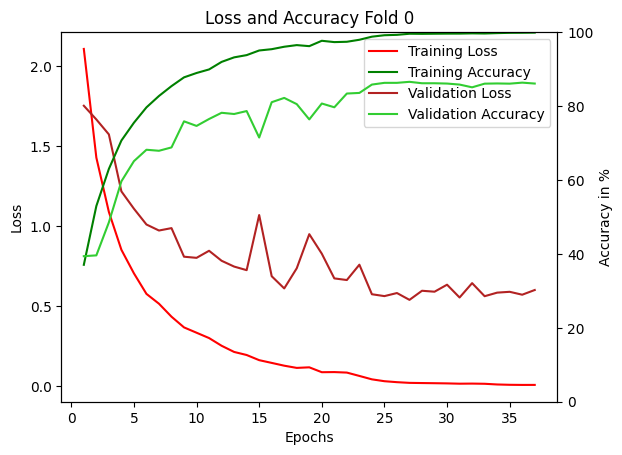

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step




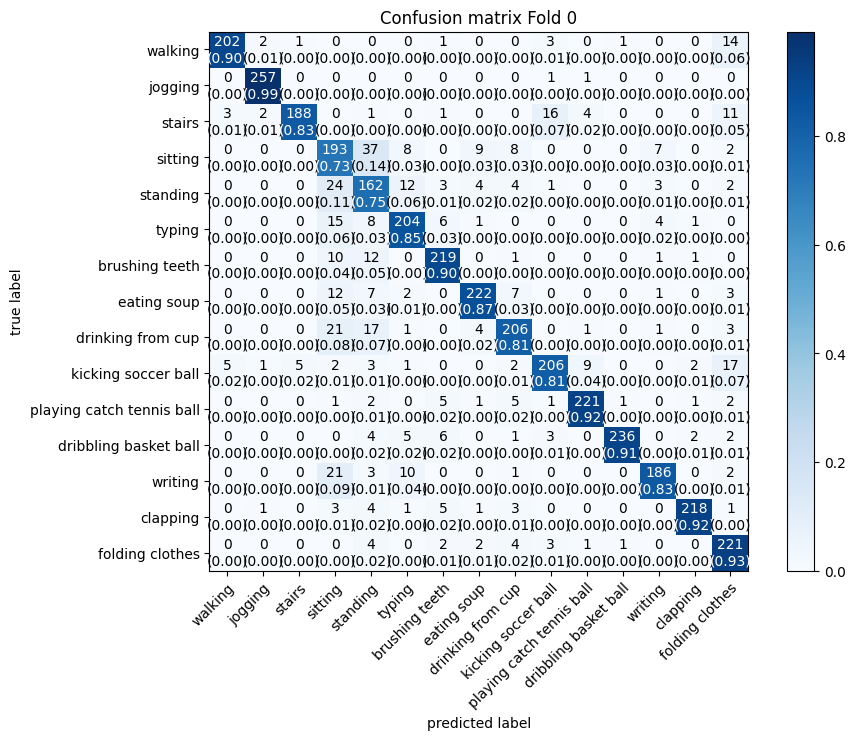

Time elapsed: 0:12:47.477210
Running fold: 1
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 363ms/step - accuracy: 0.3063 - loss: 2.6016 - val_accuracy: 0.3687 - val_loss: 1.8051 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.5228 - loss: 1.3745 - val_accuracy: 0.3607 - val_loss: 1.7304 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.6290 - loss: 1.0484 - val_accuracy: 0.4472 - val_loss: 1.5833 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.6993 - loss: 0.8507 - val_accuracy: 0.5084 - val_loss: 1.4515 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.7415 - loss: 0.7295 - val_accuracy: 0.5304 - val_loss: 1.3902 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.7850 - loss: 0.6098 - val_accuracy: 0.6757 - val_loss: 1.0388 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━

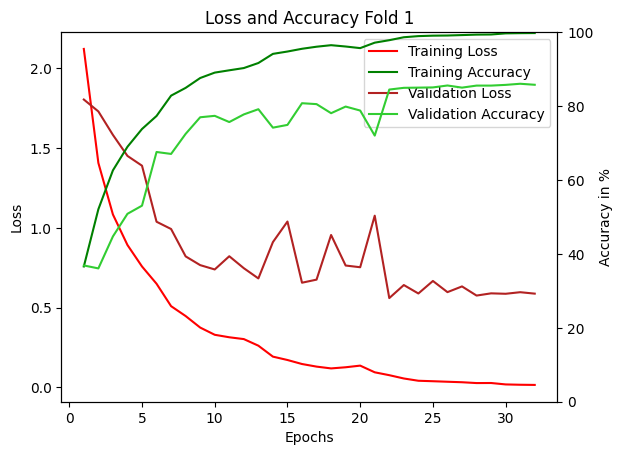

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step




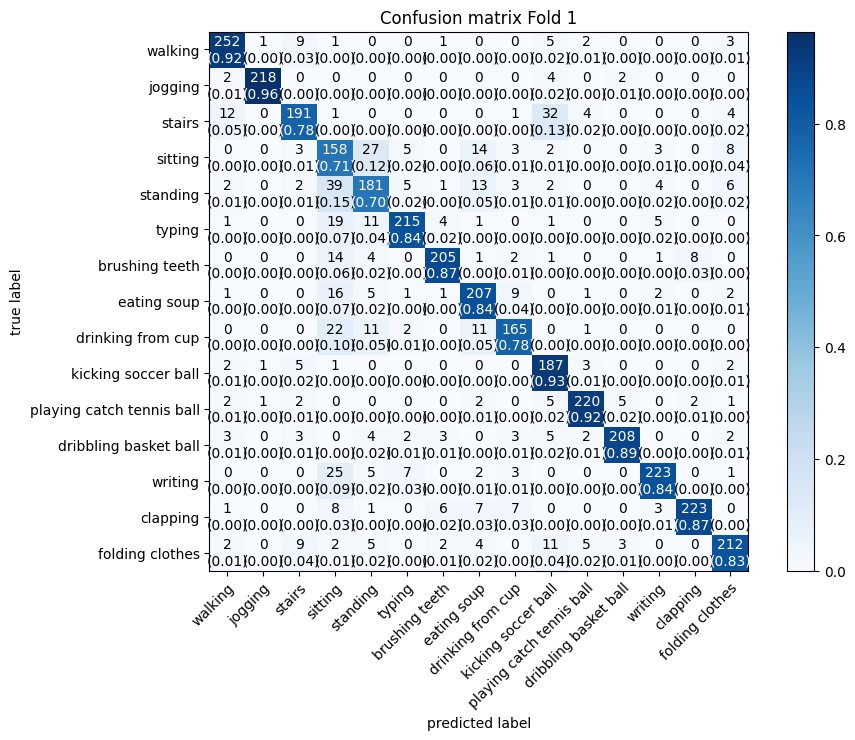

Time elapsed: 0:23:52.223473
Running fold: 2
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 362ms/step - accuracy: 0.3102 - loss: 2.4411 - val_accuracy: 0.3095 - val_loss: 1.9793 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.5210 - loss: 1.3702 - val_accuracy: 0.4173 - val_loss: 1.6954 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.6283 - loss: 1.0290 - val_accuracy: 0.4548 - val_loss: 1.6227 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.6935 - loss: 0.8435 - val_accuracy: 0.5656 - val_loss: 1.3079 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.7630 - loss: 0.6609 - val_accuracy: 0.6320 - val_loss: 1.0856 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.8023 - loss: 0.5653 - val_accuracy: 0.6814 - val_loss: 0.9476 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━

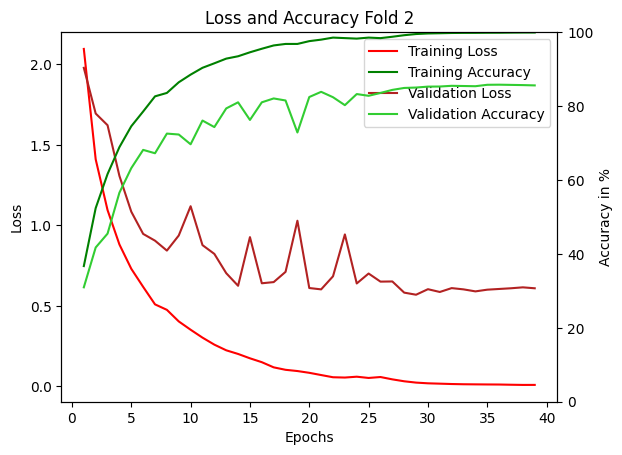

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step




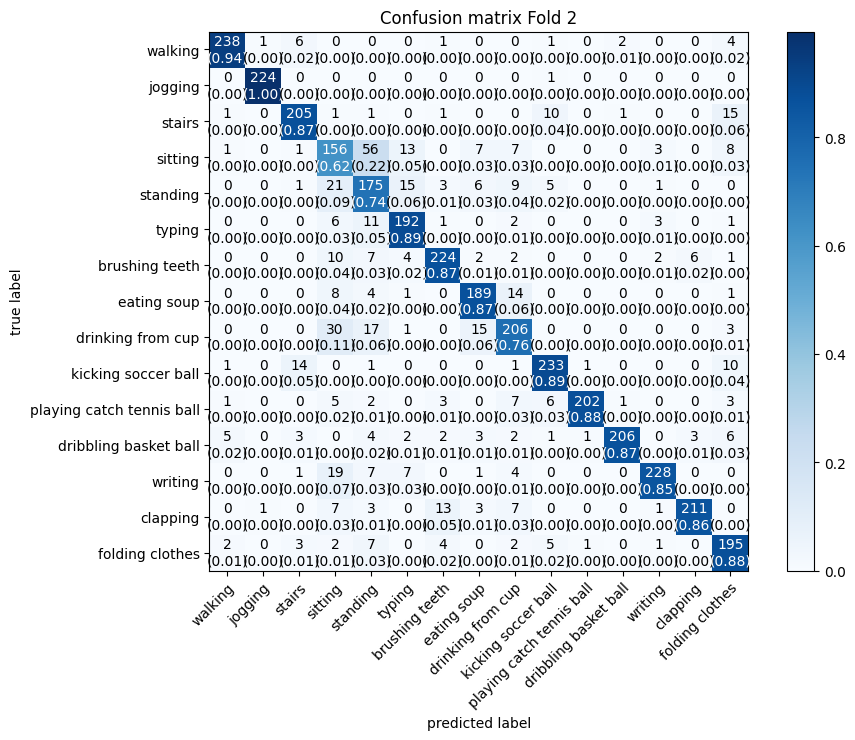

Time elapsed: 0:37:22.074901
Running fold: 3
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 364ms/step - accuracy: 0.3238 - loss: 2.4184 - val_accuracy: 0.3134 - val_loss: 1.9245 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.5443 - loss: 1.3170 - val_accuracy: 0.4465 - val_loss: 1.5798 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.6434 - loss: 1.0028 - val_accuracy: 0.4989 - val_loss: 1.4812 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.7008 - loss: 0.8478 - val_accuracy: 0.6144 - val_loss: 1.2017 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.7580 - loss: 0.6790 - val_accuracy: 0.5893 - val_loss: 1.2206 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.7894 - loss: 0.5986 - val_accuracy: 0.6420 - val_loss: 0.9955 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━

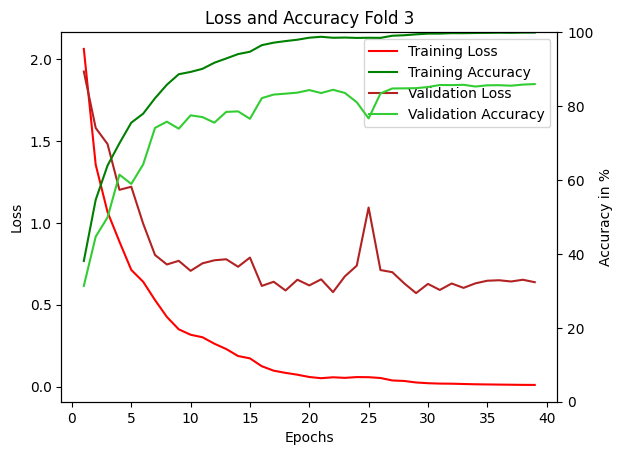

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step




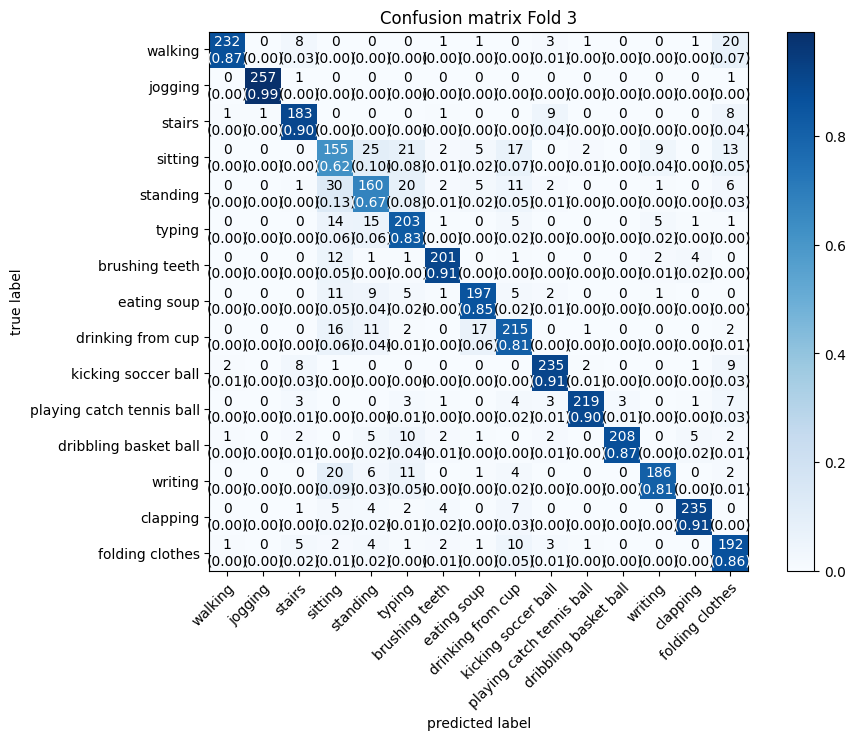

Time elapsed: 0:50:50.028307
Running fold: 4
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 362ms/step - accuracy: 0.3183 - loss: 2.3837 - val_accuracy: 0.3150 - val_loss: 1.9959 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.5364 - loss: 1.2977 - val_accuracy: 0.3768 - val_loss: 1.8024 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6400 - loss: 1.0265 - val_accuracy: 0.4551 - val_loss: 1.5987 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.7188 - loss: 0.7943 - val_accuracy: 0.5761 - val_loss: 1.2898 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.7714 - loss: 0.6381 - val_accuracy: 0.5849 - val_loss: 1.3028 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.8033 - loss: 0.5667 - val_accuracy: 0.6938 - val_loss: 0.9366 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━

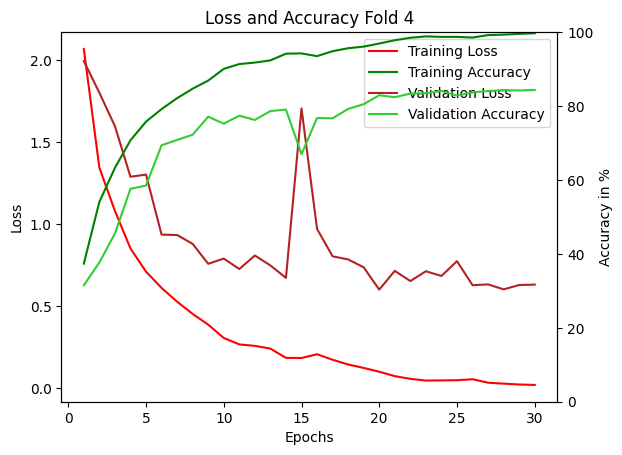

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step




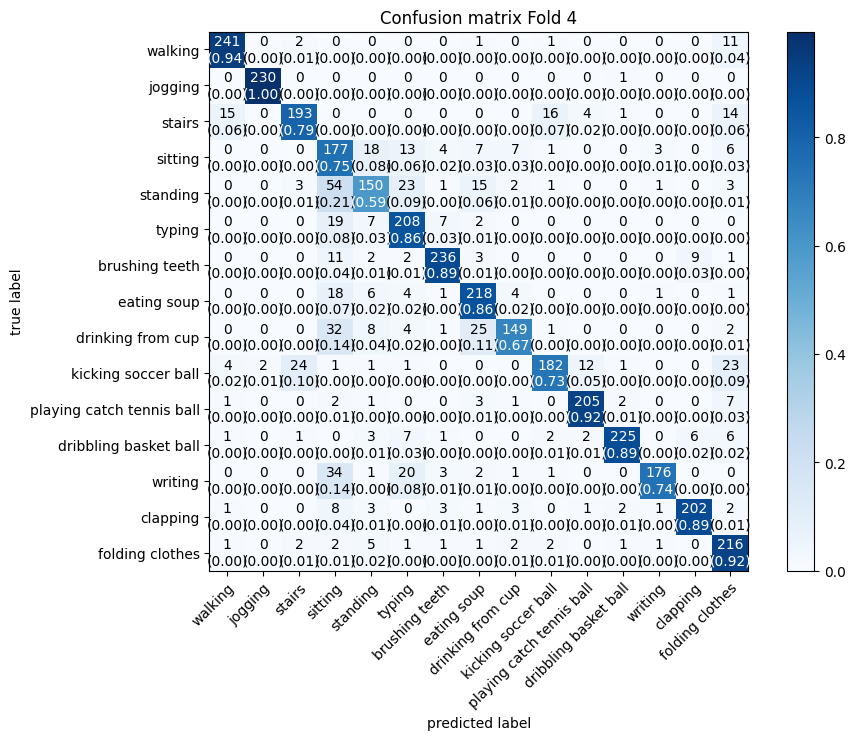

Time elapsed: 1:01:14.589794
Total Training Time: 1:01:14
Val Acc per fold: [86.08, 85.75, 85.58, 85.94, 84.34]


In [9]:
##################################################################
#Hyperparameter
##################################################################
#ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "kicking soccer ball"]
ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "drinking from cup", 
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball", 
                  "writing", "clapping", "folding clothes"]
NUM_EPOCHS = 90
BATCH_SIZE = 256
WINDOW_SIZE=200
STEP_SIZE=100
NUM_SPLITS=5
DATA_DIR="../dataset/raw/watch/gyro"

##################################################################
#Training
##################################################################
train(data_dir=DATA_DIR,
      num_splits=NUM_SPLITS,
      window_size=WINDOW_SIZE,
      step_size=STEP_SIZE,
      activity_names=ACTIVITY_NAMES,
      batch_size=BATCH_SIZE,
      num_epochs=NUM_EPOCHS)
